# Метрики качества классификации

Сегодня мы затронем вопрос, который на первый взгляд может показаться тривиальным - как измерить качество уже построенного классификатора?

Первой идеей, которая придет в голову каждому, наверняка станет метрика, которую мы с вами регулярно использовали в течение нашего курса. Начнем с неё.

# 1. Accuracy
### Доля верных ответов классификатора

Самая очевидная и интуитивно понятная метрика. Для того чтобы посчитать accuracy мы возьмём исходный датасет, состоящий из N объектов, и посмотрим сколько из них были классифицированы верно. Пусть это число M. Тогда: $$Accuracy = \frac{M}{N}$$

Казалось бы, что еще нужно?
Это ведь и есть та самая метрика, которая максимально объективно отображает эффективность нашего алгоритма!
Оказывается, у accuracy есть свои проблемы, которые зачастую делают эту метрику совсем не самой репрезентативной, а иногда - даже сбивающей с толку!

Рассмотрим пример.

### Пример
______________________
______________________

Пусть наша с вами задача - провести классификацию пациентов с подозрением на серьезную болезнь на тех, кого следует позвать на дополнительное обследование к врачу, и тех, кого можно не приглашать.

Каждый пациент описывается некоторым вектором $\vec{x}$, пусть первая координата этого вектора задает наличие жалоб у пациентов на самочувствие.

Зададим синтетический датасет следующим образом:

* Пусть у нас есть 950 здоровых людей и 50 больных.
* Пусть 40 из 50 больных чувствую себя плохо, то есть первая координата вектора их описания будет равна единице.
* Пусть среди 950 здоровых людей есть ипохондрики, то есть те, кто, будучи здоровыми, считают себя больными. Пусть их будет около 100 человек.

In [ ]:
import numpy as np
from random import shuffle
x_shape = 3
health_X = np.random.randn(950, x_shape)
f = [0]*850 + [1]*100
shuffle(f)
health_X[:,0] = f

ill_x = np.random.randn(50, x_shape)
f = [0]*10 + [1]*40
shuffle(f)
ill_x[:,0] = f

X = np.concatenate((health_X, ill_x))
Y = np.concatenate((np.zeros(950), np.ones(50)))

Датасет готов. Давайте теперь определим 2 классификатора.

Пусть один из них будет поумнее, другой - поглупее.

* Классификатор номер 1 будет давать предсказание, основываясь на самочувствии пациента
* Классификатор номер 2 будет всех определять в группу здоровых

In [ ]:
classifier_1 = lambda x: (x[:,0] == 1).astype(int) # Сравнение с признаком самочувствия
classifier_2 = lambda x: np.zeros_like(x[:,0]) # Константное предсказание

In [ ]:
y_1 = classifier_1(X) # Предсказание первого классификатора
y_2 = classifier_2(X) # Предсказание второго классификатора

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_1 = accuracy_score(y_1, Y)
accuracy_2 = accuracy_score(y_2, Y)
print(f'Точность классификатора №1 (умного): {accuracy_1}')
print(f'Точность классификатора №2 (константного): {accuracy_2}')

Точность классификатора №1 (умного): 0.89
Точность классификатора №2 (константного): 0.95


Этот результат не такой уж неожиданный. Давайте посмотрим на распределения наших групп.

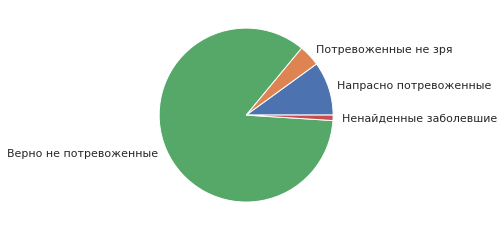

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


labels = ['Напрасно потревоженные', 'Потревоженные не зря', 'Верно не потревоженные', 'Ненайденные заболевшие']

values = [(y_1*(1-Y)).sum(), (y_1*Y).sum(), ((1-y_1)*(1-Y)).sum(), ((1-y_1)*Y).sum()]
pie = plt.pie(values,labels=labels)

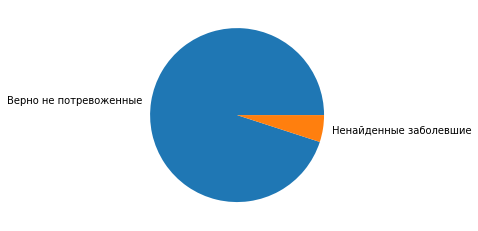

In [ ]:
labels = [ 'Верно не потревоженные', 'Ненайденные заболевшие']

values = [((1-y_2)*(1-Y)).sum(), ((1-y_2)*Y).sum()]
pie = plt.pie(values,labels=labels)

То есть доля верных ответов действительно больше для классификатора 2, поскольку он не потревожил зря ни одного здорового человека. Но и ни одного больного он не нашел.

Очевидно, что второй классификатор будет абсолютно бесполезен, если не сказать вреден, для нас. Значит, accuracy не всегда поможет нам отличить хороший классификатор от плохого.

Одна из проблем, с которой может столкнуться метрика accuracy - это **дисбаланс классов**, то есть ситуация, при которой классы не одинаково распределены в нашем датасете, одних из классов существенно больше, а других существенно меньше.

# Precision и Recall (Точность и полнота)

Прежде чем перейти к описанию этих метрики, введем понятие матрицы ошибок.

## Матрица ошибок
________________________________________________
________________________________________________
Пусть у нас есть задача бинарной классификации, датасет $\{{(x_i,y_i)}\}_{i=1}^N$

Пусть есть классификатор a(x).
Тогда каждый раз, когда мы применяем алгоритм a к объекту $x_i$ у нас есть 4 варианта:

* $a(x_i) = y_i = 0$. Такая ситуация называется **True Negative (TN)**
* $a(x_i) = y_i = 1$. Такая ситуация называется **True Positive (TP)**
* $a(x_i) = 1 \neq y_i = 0$. Такая ситуация называется **False Positive (FP)**
* $a(x_i) = 0 \neq y_i = 1$. Такая ситуация называется **False Negative (FN)**


Эту структуру обычно записывают в матрицу: считают, сколько классификаций относятся к каждому из этих классов.

В нашем случае соответствие будет следующим:

- TP = Потревоженные не зря
- FP = Зря потревоженные
- TN = Верно не потревоженные
- FN = Ненайденные заболевшие



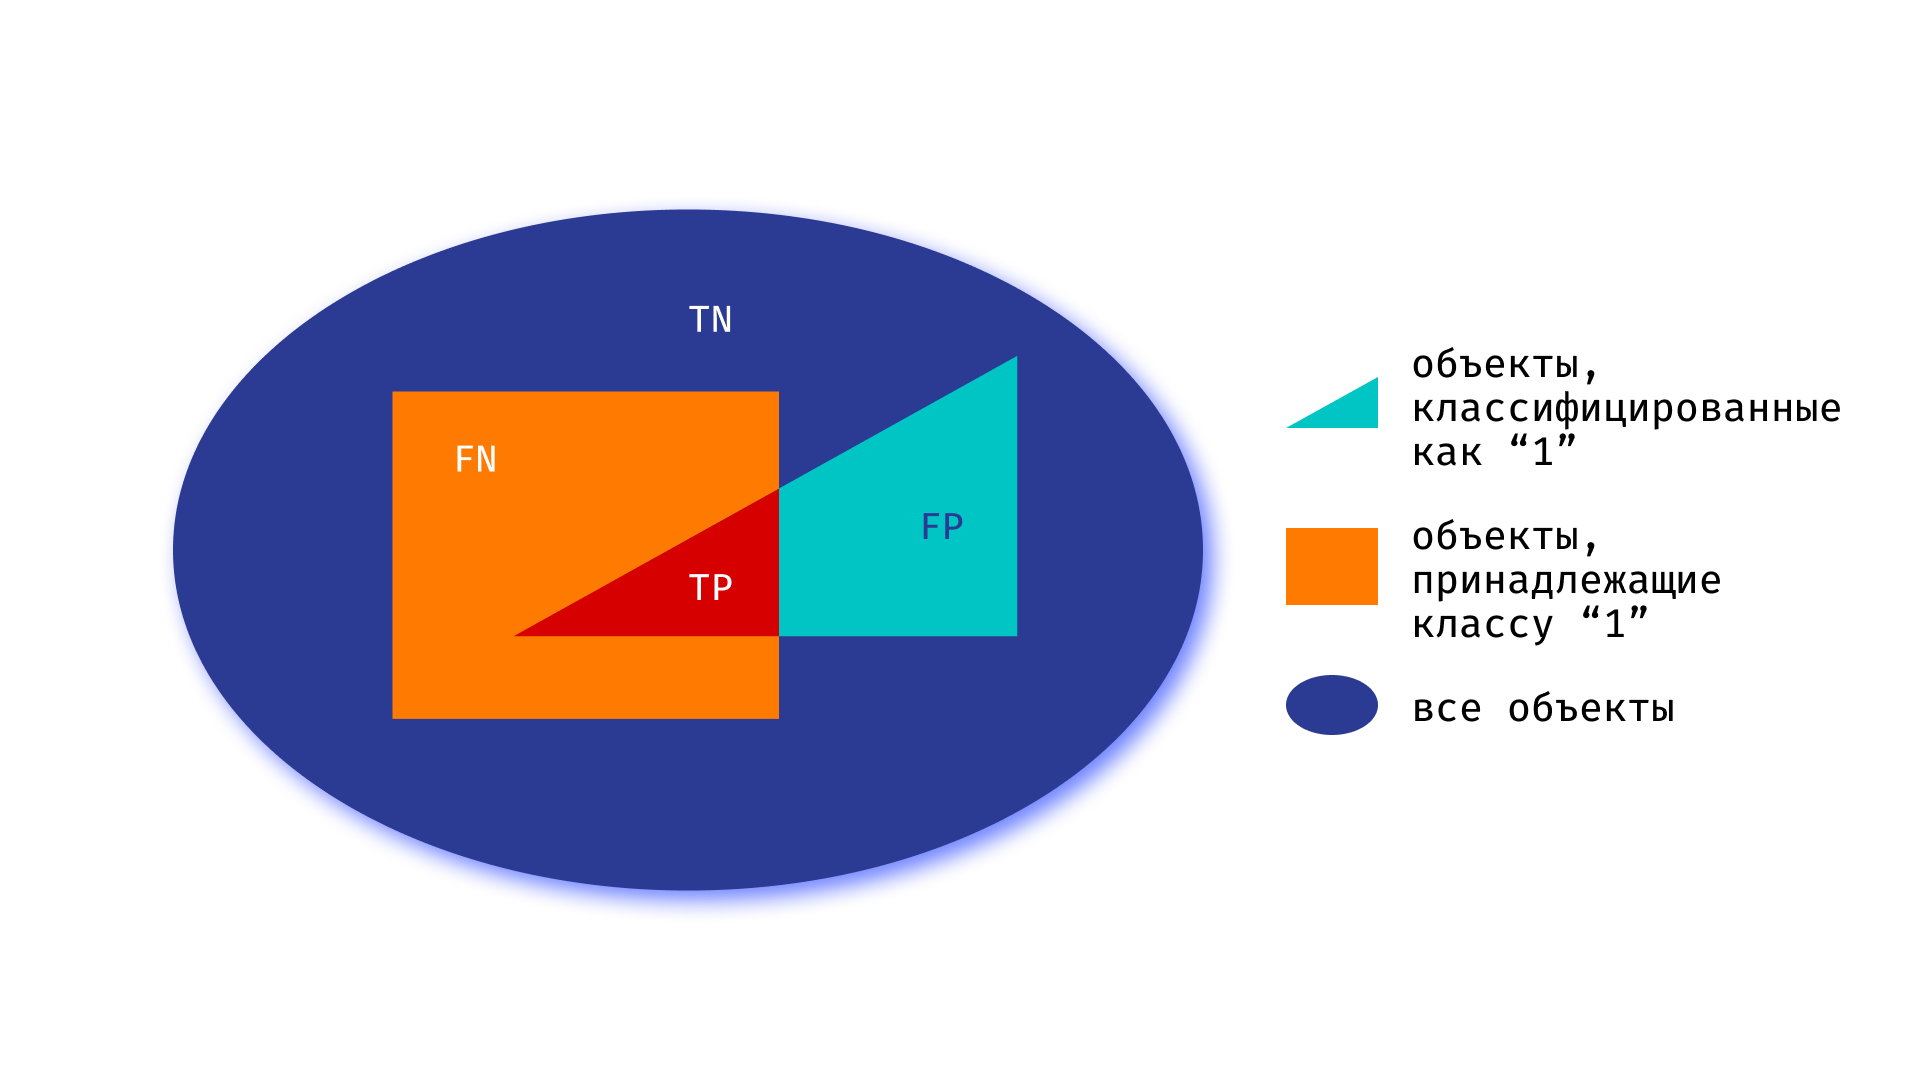

In [ ]:
import pandas as pd

TP = (y_1*Y).sum()
FP = (y_1*(1-Y)).sum()
TN = ((1-y_1)*(1-Y)).sum()
FN = ((1-y_1)*Y).sum()

TP_2 = (y_2*Y).sum()
FP_2 = (y_2*(1-Y)).sum()
TN_2 = ((1-y_2)*(1-Y)).sum()
FN_2 = ((1-y_2)*Y).sum()

df = pd.DataFrame({'a(x) = 1': [TP, FP], 'a(x) = 0': [FN, TN]}, index=['y=1', 'y=0'])
df

,a(x) = 1,a(x) = 0
y=1,40.0,10.0
y=0,100.0,850.0


________________________________________________
________________________________________________

Теперь мы рассмотрим 2 метрики, отражающие разные стороны качества классификации.





## Precision
Первая из них называется Precision (Точность)

Точность классификации определяется следующим образом:
$$Prec(X, a(x)) = \frac{TP}{TP + FP}$$

Иначе говоря, precision показывает, какую часть из приглашенных на обследование пациентов мы потревожили не зря. Чем больше precision, тем меньше потревоженных пациентов будет. Точность показывает степень уверенности в том, что объект, который классификатор определил к классу 1 **действительно принадлежит этой группе**.


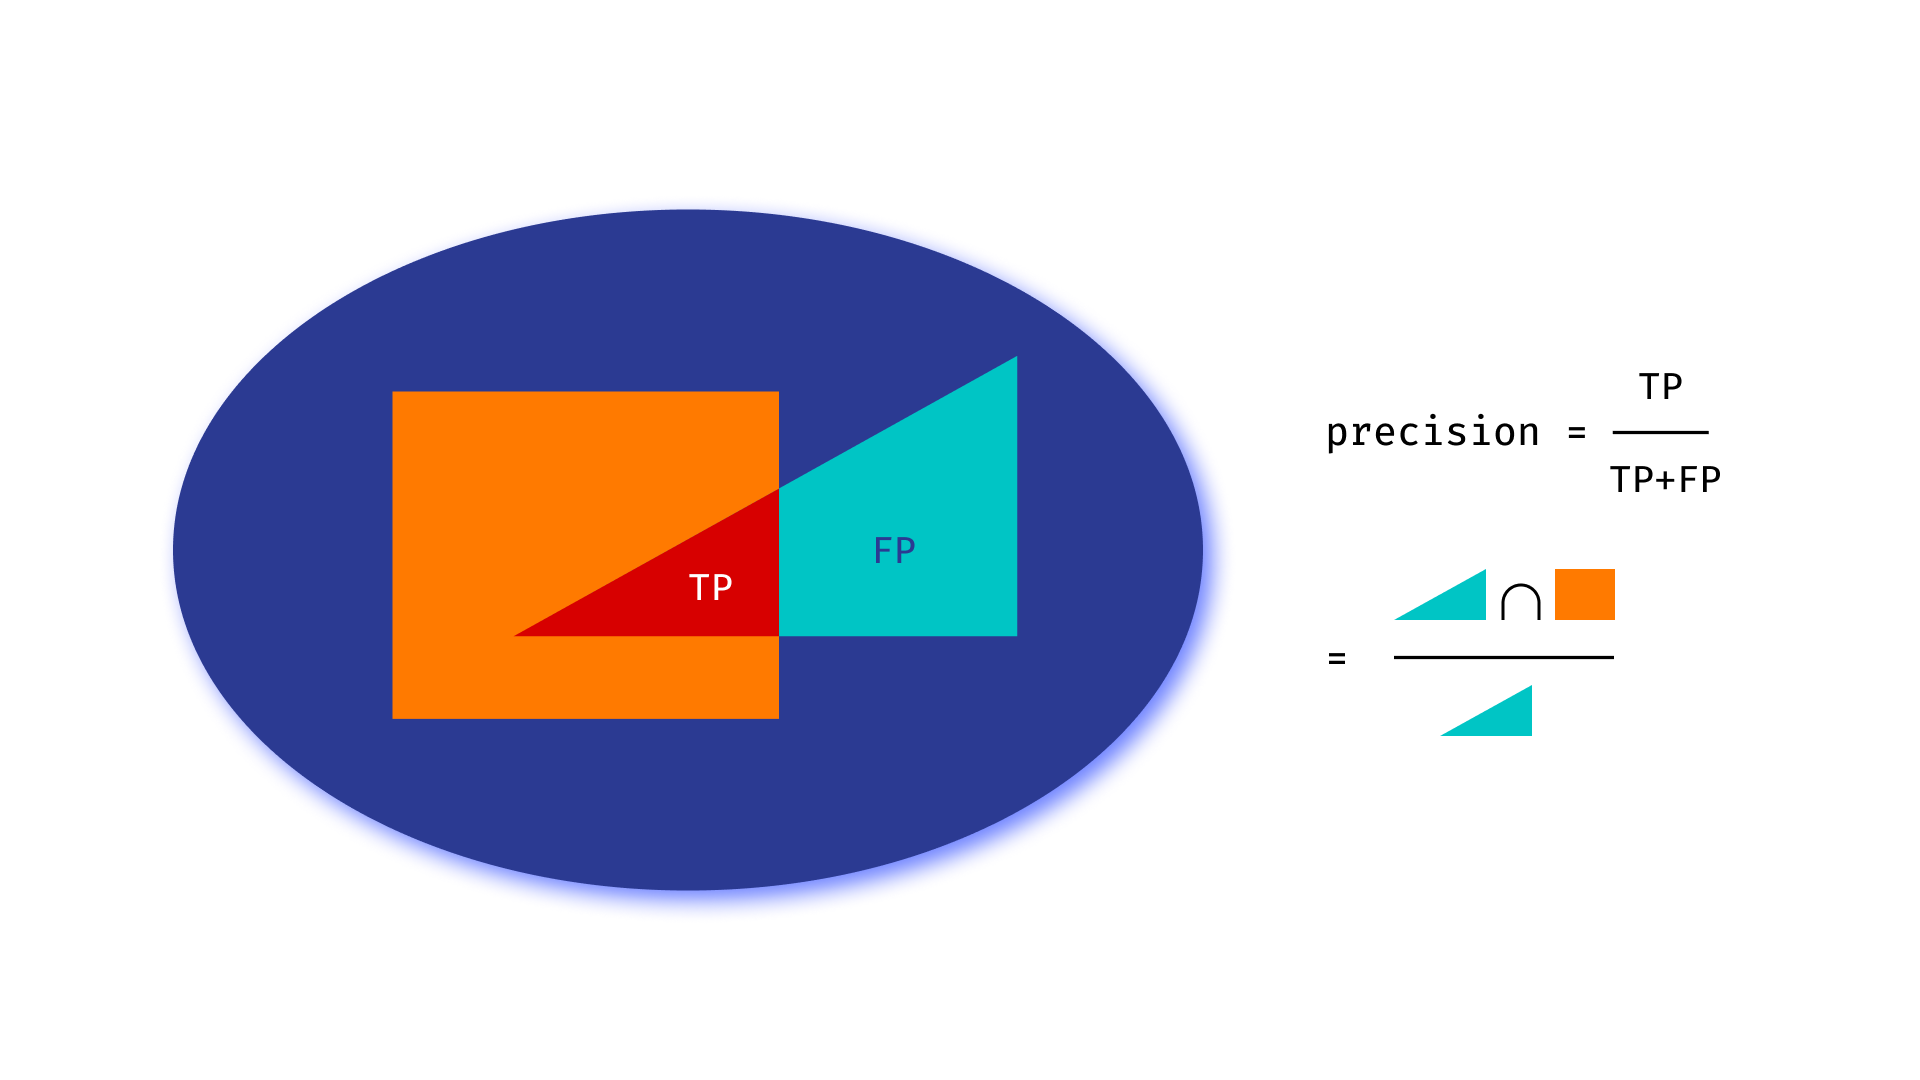

## Recall

Вторая метрика называется Recall (Полнота)
$$Rec(X, a(x)) = \frac{TP}{TP + FN}$$

Полнота же показывает нам, скольких пациентов из группы тех, кому нужна наша помощь, мы пригласили в действительности. Recall демонстрирует уверенность в том, что объект класса 1 не будет упущен нами из виду. 


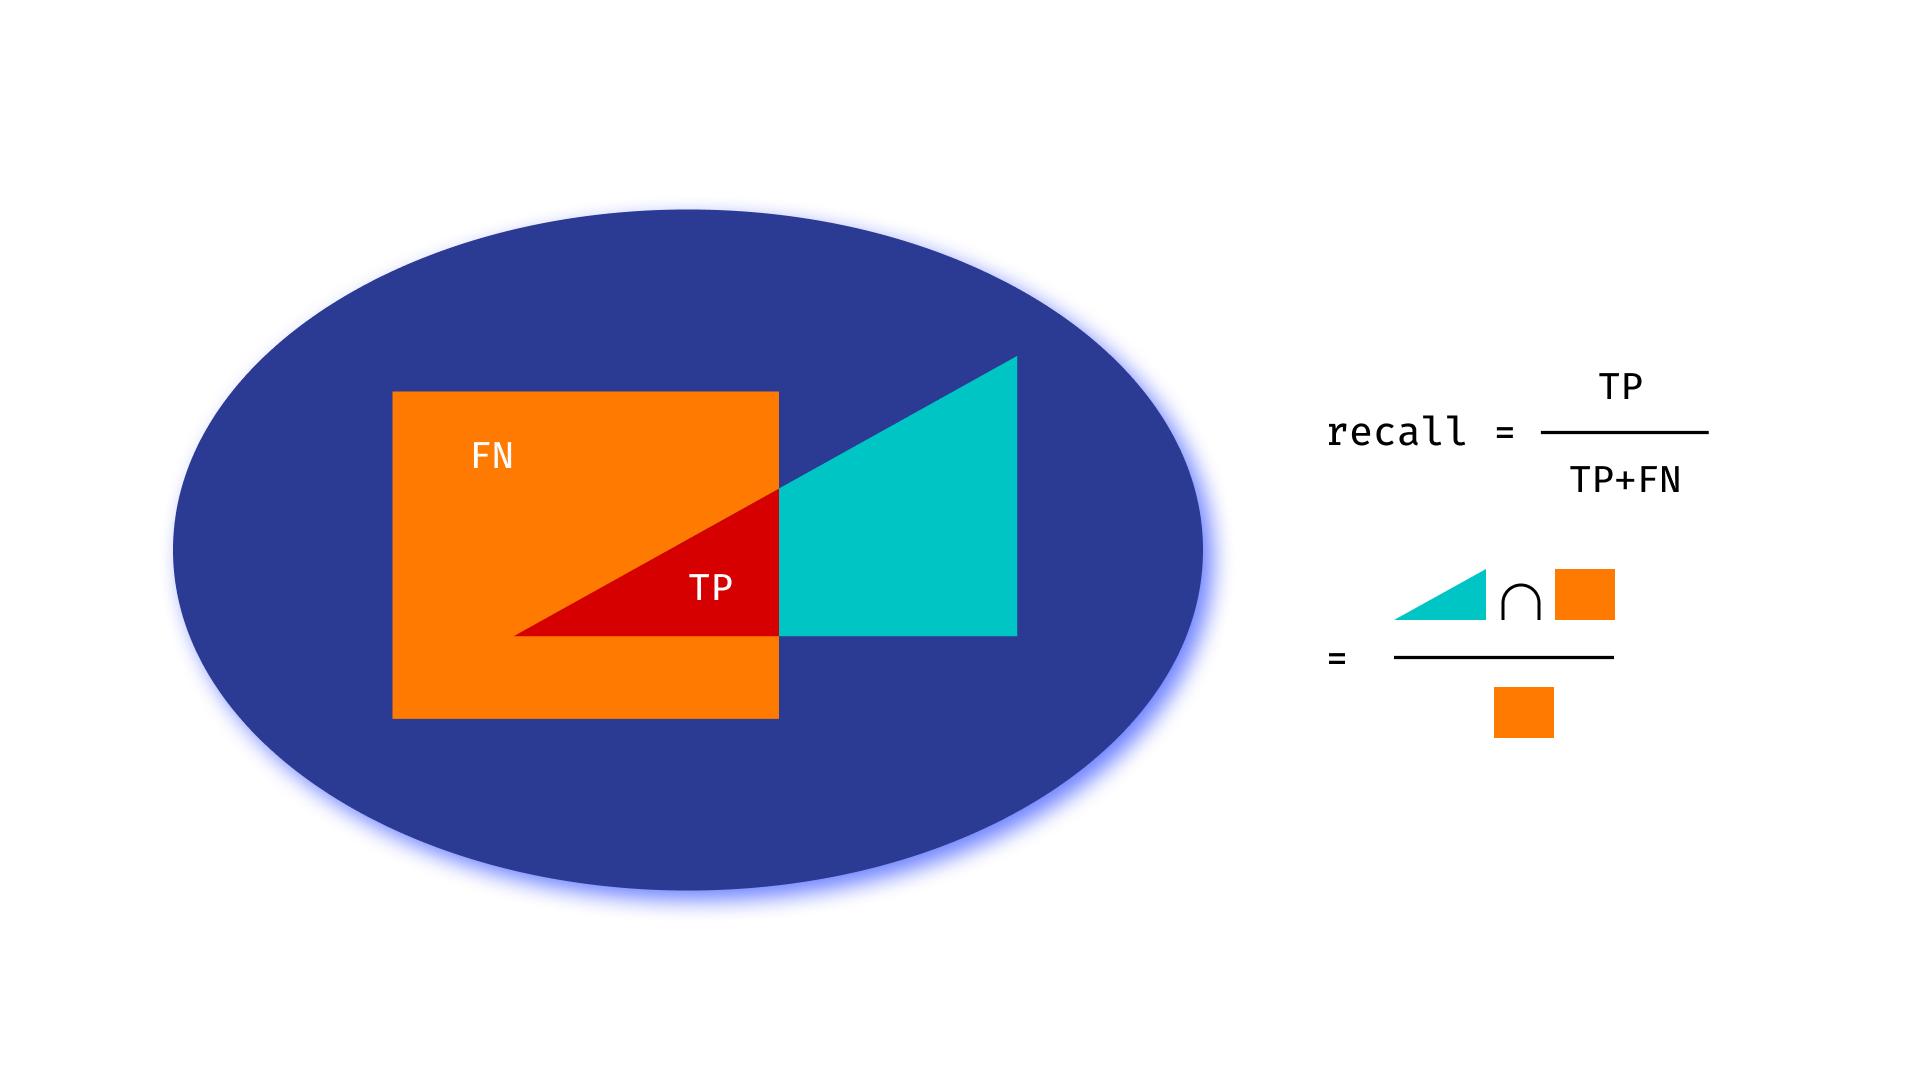

Посчитаем Precision и Recall в нашем случае

In [ ]:
precision_1 = TP/(TP + FP)
precision_2 = TP_2/(TP_2 + FP_2 + 1e-5)

recall_1 = TP/(TP + FN)
recall_2 = TP_2/(TP_2 + FN_2 + 1e-5)
print(f'Точность умного алгоритма: {precision_1}')
print(f'Точность константного алгоритма: {precision_2}')
print(f'Полнота умного алгоритма: {recall_1}')
print(f'Полнота константного алгоритма: {recall_2}')

Точность умного алгоритма: 0.2857142857142857
Точность константного алгоритма: 0.0
Полнота умного алгоритма: 0.8
Полнота константного алгоритма: 0.0


А что если у нас будет константный алгоритм, но называющим больным каждого пациента? 

In [ ]:
classifier_3 = lambda x: np.ones_like(x[:,0]) # Константное предсказание
y_3 = classifier_3(X)

In [ ]:
TP_3 = (y_3*Y).sum()
FP_3 = (y_3*(1-Y)).sum()
TN_3 = ((1-y_3)*(1-Y)).sum()
FN_3 = ((1-y_3)*Y).sum()

precision_3 = TP_3/(TP_3 + FP_3 + 1e-5)
recall_3 = TP_3/(TP_3 + FN_3 + 1e-5)

In [ ]:
print(f'Точность алгоритма-паникёра: {precision_3}')
print(f'Полнота алгоритма-паникёра: {recall_3}')

Точность алгоритма-паникёра: 0.0499999995
Полнота алгоритма-паникёра: 0.99999980000004


**Нам нужен компромисс между этими двумя метриками**



# 3. F1-measure

F1-мера пытается объединить эти две метрики в одну, следуя следующим пожеланиям:

1. При одинаковых recall значение f1 должно быть выше у того алгоритма, у которого выше precision

2. При одинаковых precision значение f1 должно быть выше у того алгоритма, у которого выше recall

3. f1 должна быть больше у того алгоритма, для которого поддерживается баланс между precision и recall при условии максимизации обеих

Таким требованиям отлично удовлетворяет среднее гармоническое precision и recall алгоритма: $$f1 = 2\frac{precision*recall}{(precision + recall)}$$

In [ ]:
f1 = lambda prec, recall: 2*prec*recall/(prec + recall + 1e-5)

In [ ]:
print(f'f1 умного алгоритма: {f1(precision_1, recall_1)}')
print(f'f1 константного алгоритма: {f1(precision_2, recall_2)}')
print(f'f1 алгоритма-паникёра: {f1(precision_3, recall_3)}')

f1 умного алгоритма: 0.42104875349832294
f1 константного алгоритма: 0.0
f1 алгоритма-паникёра: 0.09523718640304021


Конечно, нам не обязательно каждый раз писать эти метрики руками. Мы можем взять их из sklearn

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(f'f1 умного алгоритма: {f1_score(y_1, Y)}')
print(f'f1 константного алгоритма: {f1_score(y_2, Y)}')
print(f'f1 алгоритма-паникёра: {f1_score(y_3, Y)}')

f1 умного алгоритма: 0.4210526315789473
f1 константного алгоритма: 0.0
f1 алгоритма-паникёра: 0.09523809523809523


# Метрики качества мягкой классификации

Мягкая классификация - это способ проведения классификации, при котором алгоритм возвращает нам не решение в явном виде (то есть класс 1 или 0), а вероятность принадлежности объекта классу 1 (как в случае логистической регрессии).

В этом случае мы хотим учесть не только правильность ответов, но и уверенность модели в этих ответах.

Пусть $b(x_i)$ - это оценка принадлежности объекта $x_i$ классу 1. Каким образом мы проводим классификацию этого объекта?

Мы сравниваем эту оценку $b(x_i)$ со значением 0.5, то есть $$a(x_i) = [b(x_i) >0.5]$$

Значение 0.5 выбрано в данном случае из соображений того, что мы вопсринимаем $b(x_i)$ как **вероятность**. Вспомним, как во время разговора о сигмоидальной функции, которая является выходом алгоритма логистической регрессии, мы говорили, что выход сигмоиды мы можем **интерпретировать как вероятность**, но никто не гарантирует нам, что она ей является. Исходя из этого, мы можем предположить, что 0.5 - не обязательно оптимальное значение, с которым мы сравниваем выход нашего алгоритма.

То есть в общем случае, алгоритм принятия решения выглядит так: $$a_t(x_i) = [b(x_i) > t]$$ где t - некоторый определенный заранее порог.

Пусть теперь у нас есть выборка X = $\{(x_i,y_i)\}_{i=1}^N$. Упорядочим объекты $x_{(1)} ... x_{(N)}$ в порядке возрастания оценки b(x).

$$b(x_{(1)}) \leq ... \leq b(x_{(N)})$$

И переберем все эти значения в качестве порогов классификации
$$t_1 = b(x_{(1)})$$
$$...$$
$$t_N = b(x_{(N)})$$


Рассмотрим набор классификаторов $a_{t_1}(x) ... a_{t_N}(x)$ с обозначенными выше порогами классификации и одной и той же функцией b(x).

# PR-curve

Для каждого порога $t_i$ посчитаем precison и recall алгоритма $a_{t_i}(x)$. Тогда каждому из порогов $t_i$ будет соответствовать точка в координатах precision-recall.

Отметим все эти точки и последовательно соединим их, получив кусочно-линейную кривую (ломаную в школьном понимании). 



In [ ]:
# Построим PR-curve и посчитаем площадь под ней самостоятельно и при помощи функций из sklearn
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
X, y = load_breast_cancer(return_X_y = True)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

sc = StandardScaler()
sc.fit(X_train)
X_train, X_test = sc.transform(X_train), sc.transform(X_test)

In [ ]:
LR = LogisticRegression().fit(X_train, y_train)

Выведем таблицу вероятностей принадлежности каждого из объектов тестовой выборки классу "1", а также реальное распределение по классам.

In [ ]:
import pandas as pd
import numpy as np
probas = LR.predict_proba(X_test)[:,1]
infotable = pd.DataFrame({'proba': probas, 
                          'y_true': y_test})
infotable

,proba,y_true
0,0.863991,1
1,0.000023,0
2,0.003920,0
3,0.999220,1
4,0.999886,1
...,...,...
183,0.015174,0
184,0.000317,0
185,0.049865,0
186,0.413617,1


Теперь посмотрим, сколько уникальных вероятностей принадлежности объекта классу "1" есть в данном множестве

In [ ]:
set(infotable.proba)

{2.0623393340978452e-12,
 9.080918080860496e-12,
 5.368334222270351e-11,
 3.500875628256342e-10,
 7.168241913078832e-10,
 4.763252320467966e-09,
 6.277518464480854e-09,
 7.086532598779202e-09,
 9.819265213666429e-09,
 1.6111252438366346e-08,
 1.9586674579078347e-08,
 2.054819901956993e-08,
 2.397363178023633e-08,
 1.5123054210856931e-07,
 5.902849804588547e-07,
 9.988340779685224e-07,
 1.779851938263275e-06,
 2.253988078958166e-06,
 2.5720768299547324e-06,
 2.8265158392141222e-06,
 2.945678273122167e-06,
 3.655134542287457e-06,
 7.032426014473753e-06,
 2.039037319124322e-05,
 2.2643154282070446e-05,
 2.2704962200699364e-05,
 3.946927827061144e-05,
 0.00012619203225319782,
 0.00015477598214958546,
 0.0001738490523733828,
 0.00017585364669744712,
 0.00017898244785382968,
 0.00019309412488214775,
 0.00024774021717038637,
 0.00031739673684029956,
 0.0004735973738901514,
 0.0005765854103138502,
 0.0007381604213918214,
 0.0009108831472566525,
 0.001005845040864175,
 0.001100800638387287,
 0.

Довольно много. Каждую из этих вероятностей необходимо попробовать в качестве значения порога.

In [ ]:
for prob in set(infotable.proba):
  infotable[f'predicted_threshold_{prob}'] = (infotable.proba.values >= prob).astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


In [ ]:
infotable

,proba,y_true,predicted_threshold_0.8639911722546632,predicted_threshold_0.9998857059010751,predicted_threshold_0.9400737720579393,predicted_threshold_0.9928146499272053,predicted_threshold_0.9972488290882062,predicted_threshold_0.9999987173758711,predicted_threshold_0.9980925174439292,predicted_threshold_0.999762032852292,...,predicted_threshold_0.9963043199006374,predicted_threshold_0.9965120043476641,predicted_threshold_2.0623393340978452e-12,predicted_threshold_2.5720768299547324e-06,predicted_threshold_0.9997897998989519,predicted_threshold_0.003919943280444195,predicted_threshold_0.9997023731055382,predicted_threshold_0.9525428738188882,predicted_threshold_0.7660084595554437,predicted_threshold_0.9998550832193408
0,0.863991,1,1,0,0,0,0,0,0,0,...,0,0,1,1,0,1,0,0,1,0
1,0.000023,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
2,0.003920,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,1,0,0,0,0
3,0.999220,1,1,0,1,1,1,0,1,0,...,1,1,1,1,0,1,0,1,1,0
4,0.999886,1,1,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,0.015174,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,1,0,0,0,0
184,0.000317,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
185,0.049865,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,1,0,0,0,0
186,0.413617,1,0,0,0,0,0,0,0,0,...,0,0,1,1,0,1,0,0,0,0


Для каждого из этих порогов посчитаем precision и recall

In [ ]:
precisions = [precision_score(infotable['y_true'], infotable[f'predicted_threshold_{prob}']) for prob in set(infotable.proba)]
recalls = [recall_score(infotable['y_true'], infotable[f'predicted_threshold_{prob}']) for prob in set(infotable.proba)]

prec_rec_table = pd.DataFrame({'precision': precisions, 'recall': recalls})
prec_rec_table = prec_rec_table.sort_values(by=['recall', 'precision'], ascending=[True, False])
prec_rec_table

,precision,recall
19,1.000000,0.008264
5,1.000000,0.016529
148,1.000000,0.024793
137,1.000000,0.033058
108,1.000000,0.041322
...,...,...
37,0.657609,1.000000
46,0.654054,1.000000
53,0.650538,1.000000
161,0.647059,1.000000


Отлично, теперь мы можем изобразить эти точки на плоскости

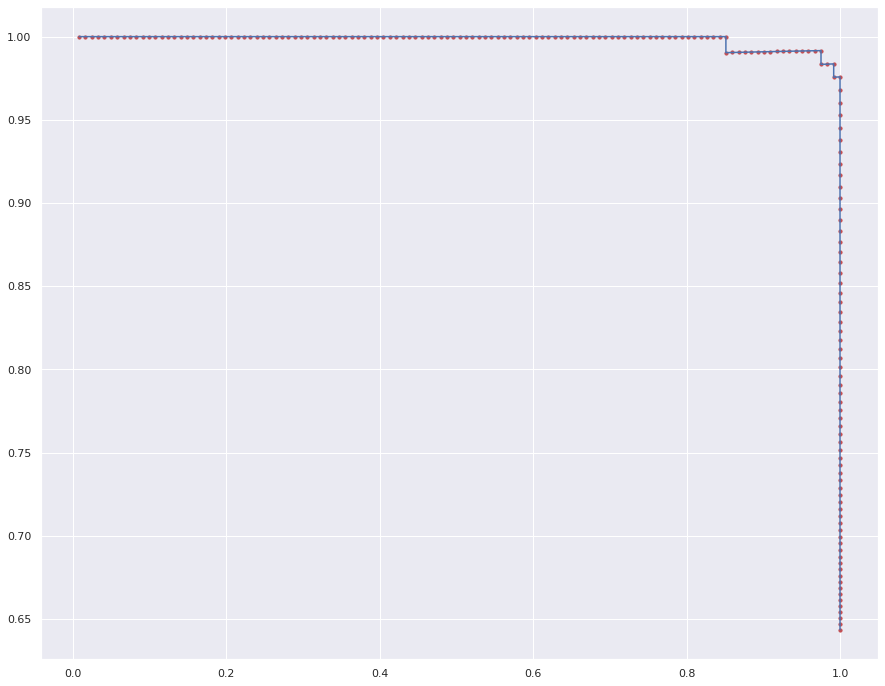

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

plt.figure(figsize=(15,12))
plt.plot(prec_rec_table.recall, prec_rec_table.precision)
plt.scatter(prec_rec_table.recall, prec_rec_table.precision, c='r', s=10)

In [ ]:
y_test.sum()/len(y_test)

0.6436170212765957

На этом графике точками отмечены полученные значения precision и recall при разных порогах классификации. Мы можем заметить, что большинство из них совершенно непригодны для решения данной задачи, поскольку создают явный перекос в одну из сторон, однако здесь же мы видим, что существует возможность улучшения одной из метрик при фиксированной второй для большинства порогов, а также ряд достаточно хороших комбинаций этих параметров (в правом верхнем углу). Именно существование этих хороших комбинаций и обуславливает довольно большую площадь под данной PR-кривой. 

Всё это можно было сделать намного проще, применив функцию из `sklearn`:

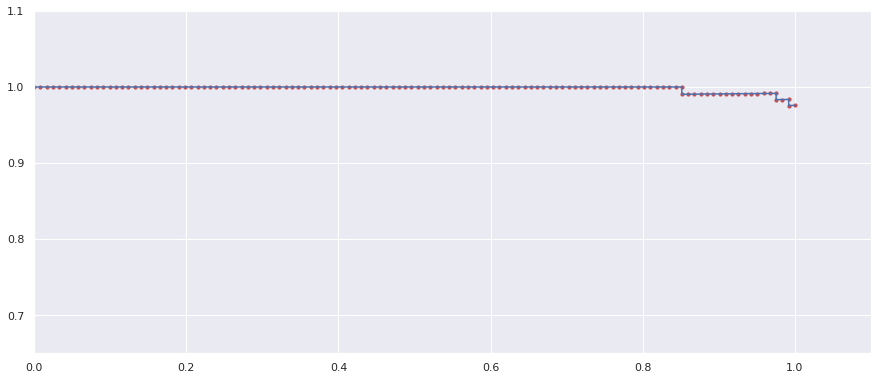

In [ ]:
from sklearn.metrics import precision_recall_curve,roc_curve
precision,recall,thresholds = precision_recall_curve(y_test,probas)

plt.figure(figsize=(15,12))
plt.plot(recall,precision)
plt.scatter(recall,precision, c='r', s=10)
plt.gca().set_aspect('equal')
plt.xlim([0.0, 1.1])
plt.ylim([0.65, 1.1])
plt.show()

In [ ]:
precision.shape

(125,)

In [ ]:
precision.shape

(125,)

Попробуем посмотреть на то, как поведёт себя случайный алгоритм.

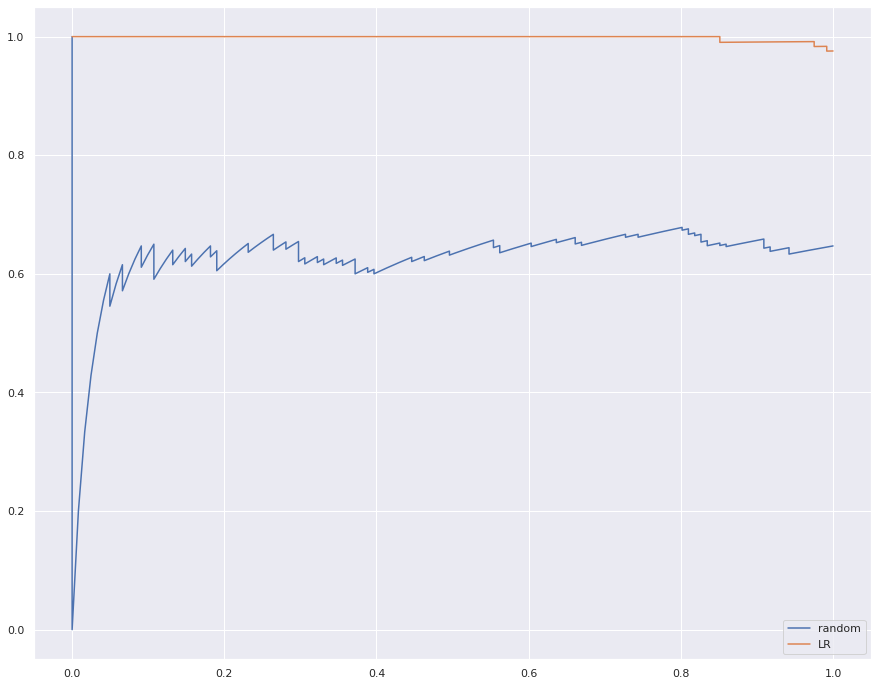

In [ ]:
from sklearn.metrics import precision_recall_curve,roc_curve
precision_,recall_,thresholds_ = precision_recall_curve(y_test,np.random.uniform(0, 1, y_test.shape[0]))

plt.figure(figsize=(15,12))
plt.plot(recall_,precision_, label='random')
plt.plot(recall,precision, label='LR')
plt.legend()
plt.show()

Заметим, что площадь под такой кривой существенно меньше, чем под кривой "разумного" алгоритма. Как мы знаем, это неслучайно


Попробуем сравнить 2 алгоритма по данной метрике. Обучим, скажем, KNNClassifier.

Посчитаем теперь площади аналогичных кривых, однако теперь уже для тестовых выборок. Сделаем мы это при помощи функции `sklearn.metrics.auc`, позволяющей посчитать площадь ломаной по её узлам, а также воспользуемся функцией `sklearn.metrics.precision_recall_curve`, чтобы не составлять вновь самостоятельно precision и recall

In [ ]:
# Посчитаем pr_auc
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

KNN = KNeighborsClassifier().fit(X_train, y_train)

knn_scores = KNN.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, knn_scores)
knn_auc_pr = auc(recall, precision)

lr_scores = LR.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, lr_scores)
lr_auc_pr = auc(recall, precision)

print(f'KNN auc pr = {knn_auc_pr}')
print(f'LR auc pr = {lr_auc_pr}')

KNN auc pr = 0.9866993077310161
LR auc pr = 0.9984125182621637


Нетрудно убедиться, что эта кривая обладает следующими свойствами:
* Левая точка кривой всегда (0,1)
* Если выборка идеально разделима, то кривая пройдет через точку (1,1)
* Чем больше площадь под кривой, тем лучше

Таким образом, площадь под PR-кривой (Precision-Recall) может быть метрикой качества мягкой классификации. Она называется AUC_PR.

# ROC-curve
Введем понятия True Positive Rate и False Positive Rate:

* False Positive Rate (FPR)
$$FPR = \frac{FP}{FP + TN}$$

Смысл этой величины - вероятность встретить ошибочную классификацию объекта класса "0".

* True Positive Rate (TPR)
$$TPR = \frac{TP}{TP + FN}$$

Смысл этой величины - вероятность встретить верную классификацию объекта класса "1".

Зададим теперь кривую, аналогичную PR-curve, но теперь в координатах TPR-FPR.

Такая кривая называется ROC-curve (reciever operating characteristic)




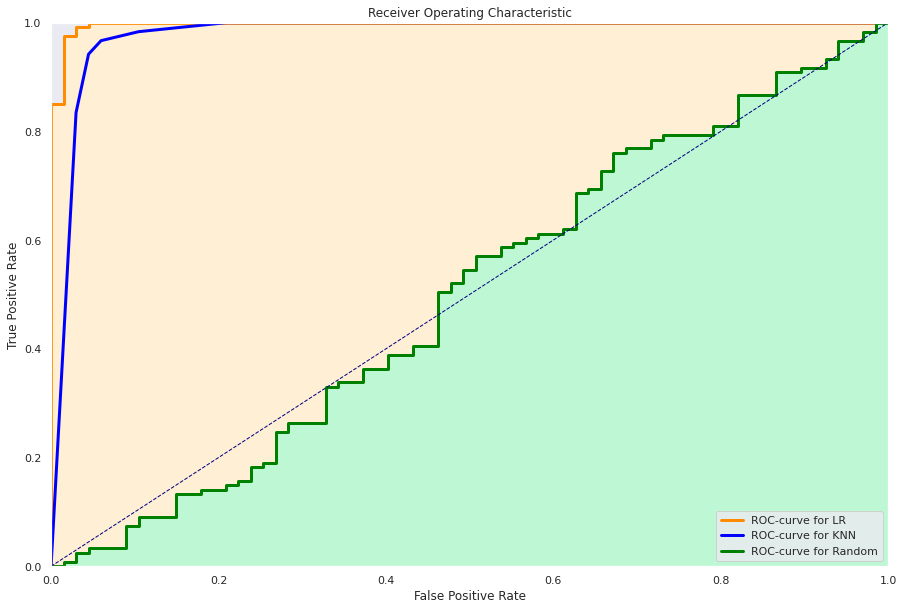

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
predictions_lr = LR.predict_proba(X_test)
predictions_knn = KNN.predict_proba(X_test)

plt.figure(figsize=(15, 10))
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, predictions_lr[:,1])
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=3, label = 'ROC-curve for LR')

fpr_knn, tpr_knn, thresholds = roc_curve(y_test, predictions_knn[:,1])
plt.plot(fpr_knn, tpr_knn, color='blue', lw=3, label = 'ROC-curve for KNN')

fpr_knn, tpr_knn, thresholds = roc_curve(y_test, np.random.uniform(0, 1, y_test.shape[0]))
plt.plot(fpr_knn, tpr_knn, color='green', lw=3, label = 'ROC-curve for Random')

plt.fill_between(fpr_lr, tpr_lr, color="papayawhip")
plt.fill_between(fpr_knn, tpr_knn, color="aquamarine", alpha=0.5)
plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


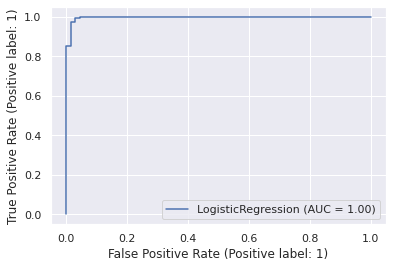

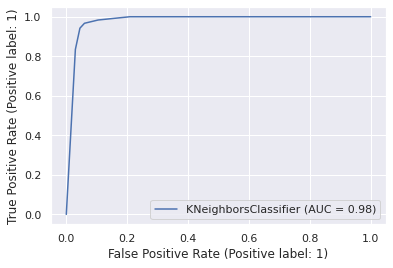

In [ ]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(LR, X_test, y_test)
plot_roc_curve(KNN, X_test, y_test)

Посчитать roc_auc можно при помощи функции `sklearn.metrics.roc_auc_score`

In [ ]:
from sklearn.metrics import roc_auc_score

knn_preds = KNN.predict(X_test)
lr_preds = LR.predict(X_test)

roc_auc_score(y_test, lr_preds)

0.9801406192179597

In [ ]:
roc_auc_score(y_test, knn_preds)

0.9536203281115087

Свойства:
* Левая точка (0,0)
* Правая точка (1,1)
* При идеально разделимой выборке кривая пройдет через (0,1)
* Чем больше площадь под кривой, тем лучше
* В случае случайного гадания площадь под кривой равна 0.5

Метрика качества, соответствующая площади под ROC-curve называется AUC-ROC

# Многоклассовая классификация

До этого момента мы рассматривали приоритетно задачу бинарной классификации. Между тем это ограничение довольно сильное. На текущий момент мы не можем решить задачу классификации и оценить качество классификации даже классического датасета Iris (Ирисы Фишера), с которым уже неоднократно встречались.

Придумаем обобщение наших идей для задачи многоклассовой классификации.

Решение задачи многоклассовой классификации строится на многократном решении задач бинарной классификации. Для этого существуют 2 подхода.

Рассмотрим эту задачу на примере уже известного нам датасета Ирисов Фишера.



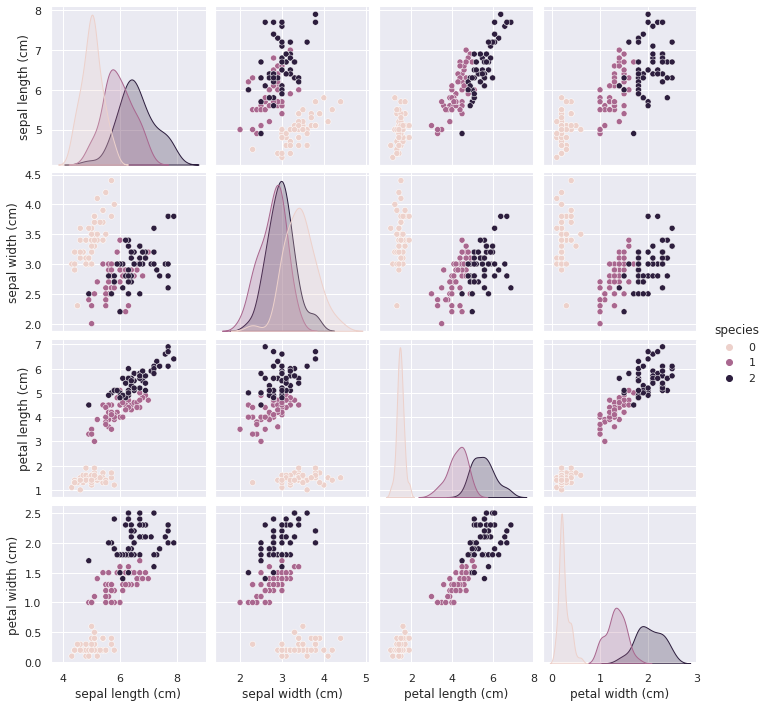

In [ ]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
iris = load_iris()
data = pd.DataFrame(iris.data, columns=iris['feature_names'])
data['species'] = iris.target
sc = StandardScaler()

X, y = load_iris(return_X_y=True)
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)
X_train = sc.fit_transform(X_train)
x_test = sc.transform(x_test)

sns.pairplot(data=data, hue="species")

Как мы видим, эта задача - типичная задача многоклассовой классификации

## I. One VS All
В этом случае, имея на руках N классов, мы построим N классификаторов $a_1 ... a_N$, каждый из которых будет решать задачу бинарной классификации, предсказывая, принадлежит ли объект i-му классу.

В данном случае нас не устроит алгоритм жесткой классификации, потому что в этом случае было бы неясно что делать, когда несколько классификаторов предсказали принадлежность некоторого объекта своему классу.

Если же алгоритм, с которым мы работаем, выдает вероятность принадлежности i-му классу, мы можем выбрать максимальную из предложенных вероятностей.

В случае подхода One vs All мы должны обучить N классификаторов на **всей** выборке (имеющей, очевидно, дисбаланс классов).



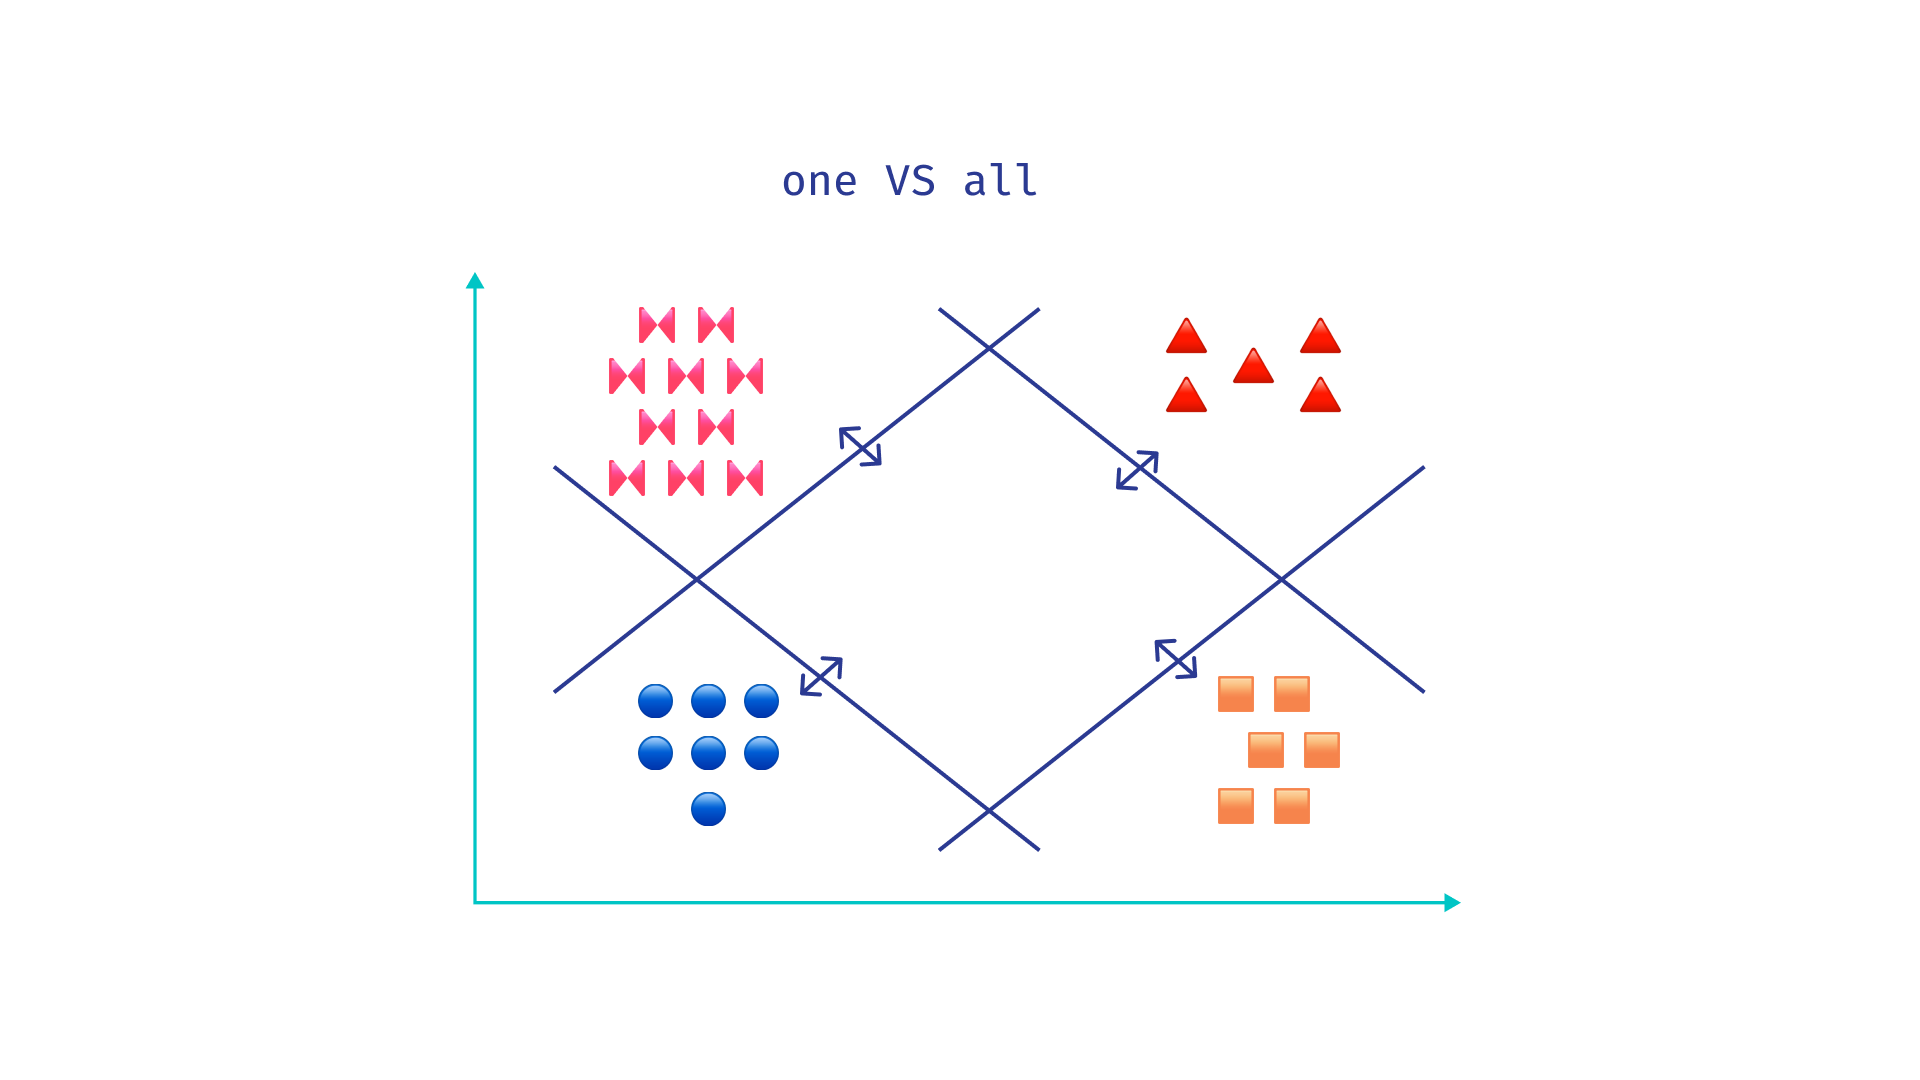

В рамках подхода One VS All мы обучим 3 классификатора, которые будут предсказывать принадлежность объекта каждому из 3 классов.

In [ ]:
y_0_train = (y_train == 0).astype(int)
y_1_train = (y_train == 1).astype(int)
y_2_train = (y_train == 2).astype(int) 

y_0_test = (y_test == 0).astype(int)
y_1_test = (y_test == 1).astype(int)
y_2_test = (y_test == 2).astype(int)

LR_0 = LogisticRegression().fit(X_train, y_0_train)
LR_1 = LogisticRegression().fit(X_train, y_1_train)
LR_2 = LogisticRegression().fit(X_train, y_2_train)

Итак, мы обучили 3 классификатора. `LR_0` предсказывает принадлежность объекта классу 0, `LR_1` - классу 1, а `LR_2` - классу 2.

Воспользуемся теперь этими классификаторами, чтобы принять решение о финальной принадлежности произвольного объекта одному из этих трёх классов.

In [ ]:
x = x_test[0]
x

array([ 0.3902305 , -0.36924864,  0.61314777,  0.34926628])

In [ ]:
# Ответ первого классификатора
p_0 = LR_0.predict_proba([x])[0][1]
p_0

0.014400147005064461

In [ ]:
# Ответ второго классификатора
p_1 = LR_1.predict_proba([x])[0][1]
p_1

0.3993054724419017

In [ ]:
# Ответ третьего классификатора
p_2 = LR_2.predict_proba([x])[0][1]
p_2

0.23831348256148868

Выберем класс с максимальной вероятностью принадлежности `x`

In [ ]:
prediction = np.argmax([p_0, p_1, p_2])
prediction

1

Узнаем, верна ли классификация

In [ ]:
y_test[0] == prediction

True

Проверим на всей тестовой выборке

In [ ]:
p_0 = LR_0.predict_proba(x_test)[:,1]
p_1 = LR_1.predict_proba(x_test)[:,1]
p_2 = LR_2.predict_proba(x_test)[:,1]

probas = np.stack([p_0, p_1, p_2])
preds = np.argmax(probas, axis=0)
preds

array([1, 2, 2, 2, 0, 2, 2, 2, 1, 1, 1, 0, 2, 1, 0, 0, 2, 2, 2, 0, 2, 2,
       1, 2, 2, 0, 1, 1, 2, 2, 1, 0, 0, 2, 2, 2, 2, 1, 2, 1, 1, 1, 0, 2,
       0])

In [ ]:
accuracy_score(preds, y_test)

0.8666666666666667

## II. All VC All

В этом случае для каждой пары классов мы обучаем свой классификатор, возвращающий вероятность принадлежности объекта одному из них. Таких классификаторов будет $C_N^2 = \frac{N(N-1)}{2}$ ~ $N^2$ штук. В качестве результата работы такого алгоритма мы вернем класс, суммарная вероятность отнести объект к которому максимальна.

В случае подхода All vs All мы должны обучить ~$N^2$ классификаторов на маленькой части выборки.



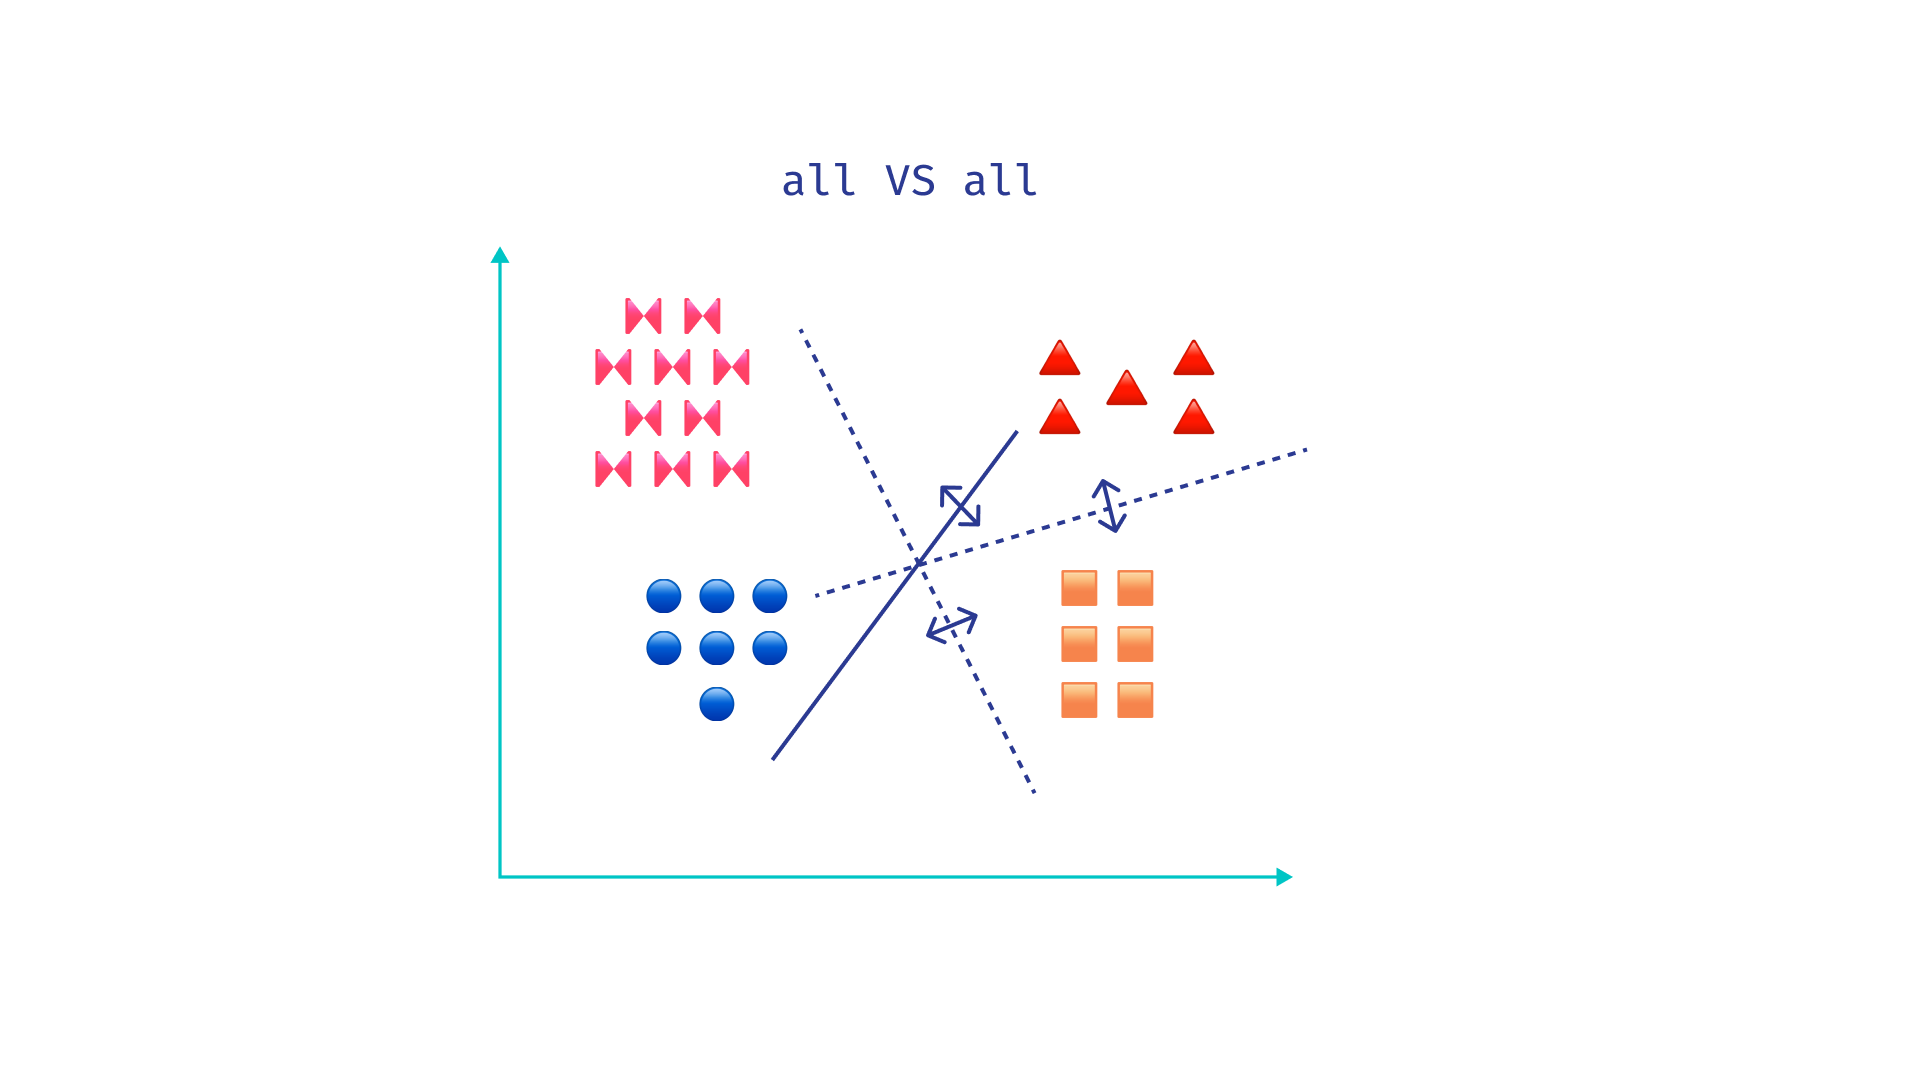

В конкретном примере с Ирисами Фишера нам вновь понадобится 3 классификатора для пар классов $[0-1]$, $[1-2]$, $[0-2]$

In [ ]:
# Пара 0-1
# Здесь мы выкидываем все объекы 2 класса
x_train_01 = X_train[y_train!=2]
y_train_01 = y_train[y_train!=2]

# Пара 0-2
# Здесь мы выкидываем все объекы 1 класса
x_train_02 = X_train[y_train!=1]
y_train_02 = y_train[y_train!=1]

# Пара 1-2
# Здесь мы выкидываем все объекы 0 класса
x_train_12 = X_train[y_train!=0]
y_train_12 = y_train[y_train!=0]

# Обучаем 3 модели
LR_01 = LogisticRegression().fit(x_train_01, y_train_01)
LR_02 = LogisticRegression().fit(x_train_02, y_train_02)
LR_12 = LogisticRegression().fit(x_train_12, y_train_12)

Введем такое обозначение: p_ij - j-я по номеру вероятность принадлежности объекта классу i

In [ ]:
p_01, p_11 = LR_01.predict_proba([x])[0]

In [ ]:
p_01

0.0157417849939

In [ ]:
p_11

0.9842582150061

In [ ]:
p_02, p_21 = LR_02.predict_proba([x])[0]

In [ ]:
p_02

0.11234036106482814

In [ ]:
p_21

0.8876596389351719

In [ ]:
p_12, p_22 = LR_12.predict_proba([x])[0]

In [ ]:
p_12

0.7614663874123682

In [ ]:
p_22

0.23853361258763184

Тогда суммарная степень принадлежности объекта классу 0:

In [ ]:
p_01 + p_02

0.12808214605872814

Классу 1:

In [ ]:
p_11 + p_12

1.745724602418468

Классу 2:

In [ ]:
p_21 + p_22

1.1261932515228037

В данном случае мы отнесем объект классу 1.

Сделаем то же самое для всех объектов тестовой выборки.

In [ ]:
P0 = LR_01.predict_proba(x_test)
p_01, p_11 = P0[:, 0], P0[:, 1]

P1 = LR_02.predict_proba(x_test)
p_02, p_21 = P1[:, 0], P1[:, 1]

P2 = LR_12.predict_proba(x_test)
p_12, p_22 = P2[:, 0], P2[:, 1]

Prob_0 = p_01 + p_02
Prob_1 = p_11 + p_12
Prob_2 = p_21 + p_22

Preds = np.argmax(np.stack([Prob_0, Prob_1, Prob_2]),axis=0)
Preds

array([1, 2, 2, 2, 0, 2, 1, 2, 1, 1, 1, 0, 1, 1, 0, 0, 2, 2, 2, 0, 1, 2,
       1, 2, 2, 0, 1, 1, 2, 2, 1, 0, 0, 1, 2, 2, 2, 1, 2, 1, 1, 1, 0, 2,
       0])

In [ ]:
accuracy_score(Preds, y_test)

0.9555555555555556

# Оценка качества многоклассовой классификации

Понятно, что precision и recall теперь недоступны для нас, так как вместо матрицы ошибок размерности 2x2 мы получаем матрицу размерности NxN, где N - число классов.

Однако если мы рассмотрим задачи отделения каждого из N классов от других, как мы уже выяснили, каждая такая задача будет задачей бинарной классификации, и для каждой из них можно посчитать свои precision и recall.

Дальше у нас вновь есть 2 пути.



## 1. Микро-усреднение
Для каждой из N задач посчитаем свои precision и recall, усредним их и на основе усреднения посчитаем итоговую метрику (roc_auc или pr_auc). 

Рассмотрим пример:

Пусть для 3 классов имеем следующую таблицу по precision и recall

In [ ]:
import pandas as pd

table = pd.DataFrame({'precision': [0.4, 0.6, 0.8], 'recall': [0.5, 0.7, 0.6]})
table

,precision,recall
0,0.4,0.5
1,0.6,0.7
2,0.8,0.6


Микроусреднение предлагает следующую стратегию поведения для вычисления усредненной f1-меры (и любой другой метрики):

In [ ]:
mean_prec, mean_rec = table.precision.mean(), table.recall.mean()
mean_f1 = 2*(mean_prec*mean_rec)/(mean_prec + mean_rec)
mean_f1

0.6

## 2. Макро-усреднение

Для каждой задачи посчитаем precision, recall и итоговую метрику. А затем усредним уже значение итоговой метрики.

Несмотря на схожесть двух этих подходов, разница может получиться довольно большой.

In [ ]:
table['f1'] = 2*(table.precision*table.recall)/(table.precision + table.recall)
table

,precision,recall,f1
0,0.4,0.5,0.444444
1,0.6,0.7,0.646154
2,0.8,0.6,0.685714


Итоговое значение f1 посчитаем следующим образом

In [ ]:
table.f1.mean()

0.5921041921041922

## Пример

In [ ]:
from sklearn.datasets import load_iris
from sklearn.metrics import roc_auc_score

X, y = load_iris(return_X_y = True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
sc = StandardScaler()
sc.fit(X_train)
X_train, X_test = sc.transform(X_train), sc.transform(X_test)

LR = LogisticRegression().fit(X_train, y_train)

In [ ]:
y_score = LR.predict_proba(X_test) 

In [ ]:
rac_1 = roc_auc_score(y_test, y_score, multi_class='ovo', average='macro')
print(f'Roc Auc для LR, macro-avereging = {rac_1}')

Roc Auc для LR, macro-avereging = 1.0
